In [2]:
import numpy as np
from scipy.stats import gamma
from scipy.stats import uniform as unif
from scipy.stats import multivariate_normal as mvtnorm
from scipy.stats import bernoulli
from numba import jit
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Indian Buffet Process Function

def sampleIBP(alpha, num_objects):  
    # Initializing storage for results
    result = np.zeros([num_objects, 1000])
    # Draw from the prior for alpha
    t = np.random.poisson(alpha)
    # Filling in first row of result matrix
    result[0, 0:t] = np.ones(t) #changed form np.ones([1, t])
    # Initializing K+
    K_plus = t
    
    for i in range(1, num_objects):
        for j in range(0, K_plus):
            p = np.array([np.log(np.sum(result[0:i,j])) - np.log(i+1), 
                          np.log(i+1 - np.sum(result[0:i, j])) - np.log(i+1)])
            p = np.exp(p - max(p))

            if(np.random.uniform() < p[0]/np.sum(p)):
                result[i, j] = 1
            else:
                result[i, j] = 0
        t = np.random.poisson(alpha/(i+1))
        x = K_plus + 1
        y = K_plus + t
        result[i, (x-1):y] = np.ones(t) #changed form np.ones([1, t])
        K_plus = K_plus+t
    result = result[:, 0:K_plus]
    
    return list([result, K_plus])

Simulated Image:

In [7]:
W = np.array([[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]])

In [9]:
#set seed
np.random.seed(1234)

#Each image in our simulated data set is the superposition of four base images#
# Number of images/ data points
num_objects=100

#Dimension of image (6x6)
object_dim  = 6*6

#Covariance matrix for images/ white noise
sigma_x_orig = 0.5
I = sigma_x_orig * np.identity(object_dim)

#z_i - binary feature matrix (1 x 4) - each entry set to 1 with probability 0.5 and 0 otherwise#
#x is data variable - each row correspondes to a superimposed built from a random combination of latent features#
#with white noise added - x is built with multivariate gaussian#
image_data = np.zeros((100,36))
z_org = np.zeros((100,4))

for i in range(0,num_objects):
    z_org[i,:] = np.array([bernoulli.rvs(p=0.5, size=4)])
    image_data[i,:] = np.dot(z_org[i,:],W) + np.random.normal(0,1, (1,object_dim)).dot(I) 

Original MCMC:

In [10]:
'''Helper Functions'''

# This function return the log likelihood
def likelihood(X, Z, M, sigma_A, sigma_X, K_plus, num_objects, object_dim):
    part1 = (-1)*num_objects*(0.5*object_dim)*np.log(2*np.pi)
    part2 = (-1)*(num_objects-K_plus)* object_dim *np.log(sigma_X) 
    part3 = (-1)*object_dim*K_plus*np.log(sigma_A) 
    part4 = (-1)*(0.5*object_dim)* np.log(np.linalg.det((np.dot(Z.T, Z) + (sigma_X**2/sigma_A**2)*np.eye(K_plus)))) 
    part5 = (-1/(2*sigma_X**2)) * np.trace(np.dot(np.dot(X.T,(np.identity(num_objects) - np.dot(np.dot(Z,M),Z.T))),X))
    total = part1+part2+part3+part4+part5
    return(total)

#This function computes matrix M
def Mcalc(Z, sigma_X, sigma_A, K_plus):
    M = np.linalg.inv(np.dot(Z.T, Z) + (sigma_X**2/sigma_A**2) * np.eye(K_plus))
    return(M)

#This function samples new value of Z[i,k] using Gibbs Sampling
def Met_zval(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim, i, k):    
    
    P=np.zeros(2)

    Z[i,k]=1
    #Compute posterior density of new_sample
    M = Mcalc(Z, sigma_X, sigma_A, K_plus)
    P[0] = likelihood(data, Z, M, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(np.sum(Z[:, k]) - Z[i,k]) - np.log(num_objects)

    #Set new_sample to 0
    Z[i,k]=0
    #Computer posterior density of new_sample
    M = Mcalc(Z, sigma_X, sigma_A, K_plus)
    P[1] = likelihood(data, Z, M, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(num_objects - np.sum(Z[:,k])) - np.log(num_objects)

    P = np.exp(P - np.max(P))

    if np.random.uniform(0,1) < (P[0]/(np.sum(P))):
        new_sample = 1
    else:
        new_sample = 0
    
    return(new_sample)


#This function samples new dishes upto a range specified by trunc_val
def New_dishes(data, Z, sigma_X, sigma_A, K_plus, alpha, num_objects, object_dim, trunc_val,i):
    trunc = np.zeros(trunc_val)
    alpha_N = alpha/num_objects

    for k_i in range(0,trunc_val):
        Z_temp = Z
        if k_i>0:
            newcol = np.zeros((num_objects, k_i))
            newcol[i,:] = 1 
            Z_temp = np.column_stack((Z_temp, newcol))
        M = Mcalc(Z_temp, sigma_X, sigma_A, K_plus+k_i)
        trunc[k_i] = k_i * np.log(alpha_N) - alpha_N - np.log(np.math.factorial(k_i)) + likelihood(data, Z_temp, M, sigma_A, sigma_X, K_plus+k_i, num_objects, object_dim)

    trunc = np.exp(trunc - np.max(trunc))
    trunc = trunc/np.sum(trunc)

    p = np.random.uniform(0,1)
    t = 0
    new_dishes = 0

    for k_i in range(0,trunc_val):
        t = t + trunc[k_i]
        if p < t:
            new_dishes = k_i
            break
            
    return(new_dishes)

#The function updates both sigma_X and sigma_A using random-walk Metropolis-Hastings.
def Met_sigma(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim):
    
    M = Mcalc(Z, sigma_X, sigma_A, K_plus)  
    lik_curr = likelihood(data, Z, M, sigma_A, sigma_X, K_plus, num_objects, object_dim)

    if np.random.uniform(0,1) < 0.5:
        sigma_X_new = sigma_X - np.random.uniform(0,1)/20
    else:
        sigma_X_new = sigma_X + np.random.uniform(0,1)/20

    M = Mcalc(Z, sigma_X_new, sigma_A, K_plus)
    lik_new_X = likelihood(data, Z, M, sigma_A, sigma_X_new, K_plus, num_objects, object_dim)

    acc_X = np.exp(min(0, lik_new_X - lik_curr))

    if np.random.uniform(0,1) < 0.5:
        sigma_A_new = sigma_A - np.random.uniform(0,1)/20
    else:
        sigma_A_new = sigma_A + np.random.uniform(0,1)/20

    M = Mcalc(Z, sigma_X, sigma_A_new, K_plus)
    lik_new_A = likelihood(data, Z, M, sigma_A_new, sigma_X, K_plus, num_objects, object_dim)

    acc_A = np.exp(min(0, lik_new_A - lik_curr))
    
    sigma_X_val=0
    sigma_A_val=0

    if np.random.uniform(0,1) < acc_X:
        sigma_X_val = sigma_X_new
    else:
        sigma_X_val = sigma_X
    
    if np.random.uniform(0,1) < acc_A:
        sigma_A_val = sigma_A_new
    else:
        sigma_A_val = sigma_A
        
    return list([sigma_X_val, sigma_A_val])

In [11]:
'''The MCMC Sampler'''

def Sampler(data, num_objects, object_dim, E=1000,  K_inf = 20, sigma_X = 1, sigma_A = 1, alpha = 1, trunc_val=5):
    #Set storage arrays for sampled parameters
    chain_Z = np.zeros([E, num_objects, K_inf])
    chain_K = np.zeros([E, 1])
    chain_sigma_X = np.zeros([E, 1])
    chain_sigma_A = np.zeros([E, 1])
    chain_alpha = np.zeros([E, 1])

    #Initialize parameter values
    num_object= np.shape(data)[0]
    object_dim = np.shape(data)[1]
    K_plus = 0
    while K_plus == 0:
        [Z, K_plus] = sampleIBP(alpha, num_objects)

    #Compute Harmonic Number
    HN = 0
    for i in range(0, num_objects):
        HN = HN + 1.0/(i+1)

    for e in range(0, E):
        #Store sampled values
        chain_Z[e, :, 0:K_plus] = Z[:, 0:K_plus]
        chain_K[e] = K_plus
        chain_sigma_X[e] = sigma_X
        chain_sigma_A[e] = sigma_A
        chain_alpha[e] = alpha

        if (e%100==0):
            print(e)
        #print("At iteration", e, ": K_plus is", K_plus, ", alpha is", alpha) 

        #Generate a new value for Z[i,k] and accept by Metropolis
        for i in range(0, num_objects):
            #First we remove singular features if any
            for k in range(0, K_plus):
                if (k>=K_plus):
                    break
                if(Z[i, k] > 0):
                    if (np.sum(Z[:, k]) - Z[i, k]) <= 0: 
                        Z[i, k] = 0
                        Z[:, k:(K_plus - 1)] = Z[:, (k+1):K_plus]
                        K_plus = K_plus - 1
                        Z = Z[:, 0:K_plus]
                        continue
                #Sample new values fo z_ik
                Z[i,k] = Met_zval(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim, i, k)

            #Sample new dishes 
            new_dishes = New_dishes(data, Z, sigma_X, sigma_A, K_plus, alpha, num_objects, object_dim, trunc_val,i)

            if(new_dishes > 0):
                newcol = np.zeros((num_objects, new_dishes))
                newcol[i,:] = 1
                Z = np.column_stack((Z, newcol))
            K_plus = K_plus + new_dishes

        #Sample sigma_X and sigma_A through Metropolis
        [sigma_X, sigma_A] = Met_sigma(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim)
        
        #Sample alpha via Gibbs
        alpha = np.random.gamma(1 + K_plus, 1/(1+HN))
    
    print("Complete")
    return list([chain_Z, chain_K, chain_sigma_X, chain_sigma_A, chain_alpha])

Optimization:

1. By algorithm:

In [12]:
'''Optimized Likelihood & Helper Functions'''

# This function return the log likelihood
def likelihood_opt(X, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim):
    #Calculate M
    M = np.dot(Z.T, Z) + (sigma_X**2/sigma_A**2)*np.eye(K_plus)
    
    part1 = (-1)*num_objects*(0.5*object_dim)*np.log(2*np.pi)
    part2 = (-1)*(num_objects-K_plus)* object_dim *np.log(sigma_X) 
    part3 = (-1)*object_dim*K_plus*np.log(sigma_A) 
    part4 = (-1)*(0.5*object_dim)* np.log(np.linalg.det(M)) 
    part5 = (-1/(2*sigma_X**2)) * np.trace(np.dot(np.dot(X.T,(np.identity(num_objects) - np.dot(np.dot(Z,np.linalg.inv(M)),Z.T))),X))
    total = part1+part2+part3+part4+part5
    return(total)



#This function samples new value of Z[i,k]
def Met_zval_opt(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim, i, k):    
    
    P=np.zeros(2)

    Z[i,k]=1
    #Compute posterior density of new_sample
    P[0] = likelihood_opt(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(np.sum(Z[:, k]) - Z[i,k]) - np.log(num_objects)

    #Set new_sample to 0
    Z[i,k]=0
    #Computer posterior density of new_sample
    P[1] = likelihood_opt(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(num_objects - np.sum(Z[:,k])) - np.log(num_objects)

    P = np.exp(P - np.max(P))

    if np.random.uniform(0,1) < (P[0]/(np.sum(P))):
        new_sample = 1
    else:
        new_sample = 0
    
    return(new_sample)

#This function samples new dishes upto a range specified by trunc_val
def New_dishes_opt(data, Z, sigma_X, sigma_A, K_plus, alpha, num_objects, object_dim, trunc_val,i):
    trunc = np.zeros(trunc_val)
    alpha_N = alpha/num_objects

    for k_i in range(0,trunc_val):
        Z_temp = Z
        if k_i>0:
            newcol = np.zeros((num_objects, k_i))
            newcol[i,:] = 1 
            Z_temp = np.column_stack((Z_temp, newcol))
        trunc[k_i] = k_i * np.log(alpha_N) - alpha_N - np.log(np.math.factorial(k_i)) + likelihood_opt(data, Z_temp, sigma_A, sigma_X, K_plus+k_i, num_objects, object_dim)

    trunc = np.exp(trunc - np.max(trunc))
    trunc = trunc/np.sum(trunc)

    p = np.random.uniform(0,1)
    t = 0
    new_dishes = 0

    for k_i in range(0,trunc_val):
        t = t + trunc[k_i]
        if p < t:
            new_dishes = k_i
            break
            
    return(new_dishes)

#The function updates both sigma_X and sigma_A using random-walk Metropolis-Hastings.
def Met_sigma_opt(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim):
     
    lik_curr = likelihood_opt(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim)

    if np.random.uniform(0,1) < 0.5:
        sigma_X_new = sigma_X - np.random.uniform(0,1)/20
    else:
        sigma_X_new = sigma_X + np.random.uniform(0,1)/20

    lik_new_X = likelihood_opt(data, Z, sigma_A, sigma_X_new, K_plus, num_objects, object_dim)

    acc_X = np.exp(min(0, lik_new_X - lik_curr))

    if np.random.uniform(0,1) < 0.5:
        sigma_A_new = sigma_A - np.random.uniform(0,1)/20
    else:
        sigma_A_new = sigma_A + np.random.uniform(0,1)/20

    lik_new_A = likelihood_opt(data, Z, sigma_A_new, sigma_X, K_plus, num_objects, object_dim)

    acc_A = np.exp(min(0, lik_new_A - lik_curr))
    
    sigma_X_val=0
    sigma_A_val=0

    if np.random.uniform(0,1) < acc_X:
        sigma_X_val = sigma_X_new
    else:
        sigma_X_val = sigma_X
    
    if np.random.uniform(0,1) < acc_A:
        sigma_A_val = sigma_A_new
    else:
        sigma_A_val = sigma_A
        
    return list([sigma_X_val, sigma_A_val])

In [13]:
def sampler_opt(data, num_objects, object_dim, E=1000,  K_inf = 20, sigma_X = 1, sigma_A = 1, alpha = 1, trunc_val=5):
    #Set storage arrays for sampled parameters
    chain_Z = np.zeros([E, num_objects, K_inf])
    chain_K = np.zeros([E, 1])
    chain_sigma_X = np.zeros([E, 1])
    chain_sigma_A = np.zeros([E, 1])
    chain_alpha = np.zeros([E, 1])

    #Initialize parameter values
    num_object= np.shape(data)[0]
    object_dim = np.shape(data)[1]
    K_plus = 0
    while K_plus == 0:
        [Z, K_plus] = sampleIBP(alpha, num_objects)

    #Compute Harmonic Number
    HN = 0
    for i in range(0, num_objects):
        HN = HN + 1.0/(i+1)

    for e in range(0, E):
        #Store sampled values
        chain_Z[e, :, 0:K_plus] = Z[:, 0:K_plus]
        chain_K[e] = K_plus
        chain_sigma_X[e] = sigma_X
        chain_sigma_A[e] = sigma_A
        chain_alpha[e] = alpha

        if (e%100==0):
            print(e)
        #print("At iteration", e, ": K_plus is", K_plus, ", alpha is", alpha) 

        #Generate a new value for Z[i,k] and accept by Metropolis
        for i in range(0, num_objects):
            #First we remove singular features if any
            for k in range(0, K_plus):
                if (k>=K_plus):
                    break
                if(Z[i, k] > 0):
                    if (np.sum(Z[:, k]) - Z[i, k]) <= 0: 
                        Z[i, k] = 0
                        Z[:, k:(K_plus - 1)] = Z[:, (k+1):K_plus]
                        K_plus = K_plus - 1
                        Z = Z[:, 0:K_plus]
                        continue
                #Compute conditional distribution for current cell
                Z[i,k] = Met_zval_opt(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim, i, k)


            #Sample new dishes by Metropolis
            new_dishes = New_dishes_opt(data, Z, sigma_X, sigma_A, K_plus, alpha, num_objects, object_dim, trunc_val,i)

            if(new_dishes > 0):
                newcol = np.zeros((num_objects, new_dishes))
                newcol[i,:] = 1
                Z = np.column_stack((Z, newcol))
            K_plus = K_plus + new_dishes

        #Sample sigma_X and sigma_A through Metropolis
        [sigma_X, sigma_A] = Met_sigma_opt(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim)
        #Sample alpha via Gibbs
        alpha = np.random.gamma(1 + K_plus, 1/(1+HN))
    
    print("Complete")
    return list([chain_Z, chain_K, chain_sigma_X, chain_sigma_A, chain_alpha])

2. By Cython:

In [14]:
%load_ext cython

In [15]:
%%cython

import numpy as np
cimport numpy as np
import cython
from libc.math cimport log

cdef double pi = 3.141592653589793

cdef sampleIBP_c(double alpha, long num_objects):  
    cdef long i, j
    cdef long t
    cdef long x
    cdef long y
    cdef long K_plus

    # Initializing storage for results
    result = np.zeros([num_objects, 1000])

    # Draw from the prior for alpha
    t = np.random.poisson(alpha)
    # Filling in first row of result matrix
    result[0, 0:t] = np.ones(t) #changed form np.ones([1, t])
    # Initializing K+
    K_plus = t
    
    for i in range(1, num_objects):
        for j in range(0, K_plus):
            p = np.array([log(np.sum(result[0:i,j])) - log(i+1), 
                          log(i+1 - np.sum(result[0:i, j])) - log(i+1)])
            p = np.exp(p - max(p))

            if(np.random.uniform() < p[0]/np.sum(p)):
                result[i, j] = 1
            else:
                result[i, j] = 0
        t = np.random.poisson(alpha/(i+1))
        x = K_plus + 1
        y = K_plus + t
        result[i, (x-1):y] = np.ones(t) #changed form np.ones([1, t])
        K_plus = K_plus+t
    result = result[:, 0:K_plus]

    return list([result, K_plus])

cdef double likelihood_opt_c(double[:,:] X, double[:, :] Z, double sigma_A, double sigma_X, 
                     long K_plus, long num_objects, long object_dim):

    #Calculate M
    cdef double[:, :] M = np.dot(Z.T, Z) + (sigma_X**2/sigma_A**2)*np.eye(K_plus)
    cdef double part1, part2, part3, part4, part5, total

    part1 = (-1)*num_objects*(0.5*object_dim)*log(2*pi)
    part2 = (-1)*(num_objects-K_plus)* object_dim *log(sigma_X) 
    part3 = (-1)*object_dim*K_plus*log(sigma_A) 
    part4 = (-1)*(0.5*object_dim)* log(np.linalg.det(M)) 
    part5 = (-1/(2*sigma_X**2)) * np.trace(np.dot(np.dot(X.T,(np.identity(num_objects) - np.dot(np.dot(Z,np.linalg.inv(M)),Z.T))),X))
    total = part1+part2+part3+part4+part5

    return(total)

#This function samples new value of Z[i,k] and accepts by Metropolis
cdef int Met_zval_c(double[:, :] data, double[:,:] Z, double sigma_X, double sigma_A, int K_plus, long num_objects, long object_dim, long i, long k):    
    
    cdef double[:]  P
    cdef int new_sample
    
    P=np.zeros(2)

    Z[i,k]=1
    #Compute posterior density of new_sample
    P[0] = likelihood_opt_c(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim) + log(np.sum(Z[:, k]) - Z[i,k]) - log(num_objects)

    #Set new_sample to 0
    Z[i,k]=0
    #Computer posterior density of new_sample
    P[1] = likelihood_opt_c(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim) + log(num_objects - np.sum(Z[:,k])) - log(num_objects)

    P = np.exp(P - np.max(P))

    if np.random.uniform(0,1) < (P[0]/(np.sum(P))):
        new_sample = 1
    else:
        new_sample = 0
    
    return(new_sample)


cdef int New_dishes_c(double[:,:] data, double[:,:] Z, double sigma_X, double  sigma_A, int K_plus, double alpha, long num_objects, long object_dim, long trunc_val, long i):
    
    trunc = np.zeros(trunc_val)
    cdef double alpha_N = alpha/num_objects
    cdef int k_i, new_dishes
    cdef double[:,:] Z_temp, newcol
    cdef double p, t
    

    for k_i in range(0,trunc_val):
        Z_temp = Z
        if k_i>0:
            newcol = np.zeros((num_objects, k_i))
            newcol[i,:] = 1 
            Z_temp = np.column_stack((Z_temp, newcol))
        trunc[k_i] = k_i * log(alpha_N) - alpha_N - log(np.math.factorial(k_i)) + likelihood_opt_c(data, Z_temp, sigma_A, sigma_X, K_plus+k_i, num_objects, object_dim)

    trunc = np.exp(trunc - np.max(trunc))
    trunc = trunc/np.sum(trunc)

    p = np.random.uniform(0,1)
    t = 0
    new_dishes = 0

    for k_i in range(0,trunc_val):
        t = t + trunc[k_i]
        if p < t:
            new_dishes = k_i
            break
            
    return(new_dishes)


cdef Met_sigma_c(double[:,:] data, double[:,:] Z, double sigma_X, double sigma_A, int K_plus, long num_objects, long object_dim):
    
    cdef double sigma_X_new, sigma_A_new, lik_new_X, lik_new_A, acc_X, acc_A, sigma_X_val, sigma_A_val 
    
    cdef double lik_curr = likelihood_opt_c(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim)

    if np.random.uniform(0,1) < 0.5:
        sigma_X_new = sigma_X - np.random.uniform(0,1)/20
    else:
        sigma_X_new = sigma_X + np.random.uniform(0,1)/20

    lik_new_X = likelihood_opt_c(data, Z, sigma_A, sigma_X_new, K_plus, num_objects, object_dim)

    acc_X = np.exp(min(0, lik_new_X - lik_curr))

    if np.random.uniform(0,1) < 0.5:
        sigma_A_new = sigma_A - np.random.uniform(0,1)/20
    else:
        sigma_A_new = sigma_A + np.random.uniform(0,1)/20

    lik_new_A = likelihood_opt_c(data, Z, sigma_A_new, sigma_X, K_plus, num_objects, object_dim)

    acc_A = np.exp(min(0, lik_new_A - lik_curr))
    
    sigma_X_val=0
    sigma_A_val=0

    if np.random.uniform(0,1) < acc_X:
        sigma_X_val = sigma_X_new
    else:
        sigma_X_val = sigma_X
    
    if np.random.uniform(0,1) < acc_A:
        sigma_A_val = sigma_A_new
    else:
        sigma_A_val = sigma_A
        
    return list([sigma_X_val, sigma_A_val])



def sampler_opt_c(double[:,:] data, long E=1000, long K_inf = 20, double sigma_X = 1, double sigma_A = 1, double alpha = 1, int trunc_val=5):
    
    cdef long num_objects= np.shape(data)[0]
    cdef long object_dim = np.shape(data)[1]
    
    #Set storage arrays for sampled parameters
    cdef double[:, :, :] chain_Z = np.zeros([E, num_objects, K_inf])
    cdef double[:, :] chain_K = np.zeros([E, 1])
    cdef double[:, :] chain_sigma_X = np.zeros([E, 1])
    cdef double[:, :] chain_sigma_A = np.zeros([E, 1])
    cdef double[:, :] chain_alpha = np.zeros([E, 1])
    
    cdef double HN
    cdef long i, e, j1, j2, k, k_i, TEMP

    #Initialize parameter values
    
    K_plus = 0
    while K_plus == 0:
        [Z, K_plus] = sampleIBP_c(alpha, num_objects)

    #Compute Harmonic Number
    HN = 0
    for i in range(0, num_objects):
        HN = HN + 1.0/(i+1)

    for e in range(0, E):
        #Store sampled values
        for j1 in range(num_objects):
            for j2 in range(K_plus):
                chain_Z[e, j1, j2] = Z[j1, j2]
        chain_K[e] = K_plus
        chain_sigma_X[e] = sigma_X
        chain_sigma_A[e] = sigma_A
        chain_alpha[e] = alpha

        #if (e%100==0):
        #    print(e)
        #print("At iteration", e, ": K_plus is", K_plus, ", alpha is", alpha) 

        #Generate a new value for Z[i,k] and accept by Metropolis
        for i in range(0, num_objects):
            #First we remove singular features if any
            for k in range(0, K_plus):
                if (k>=K_plus):
                    break
                if(Z[i, k] > 0):
                    if (np.sum(Z[:, k]) - Z[i, k]) <= 0: 
                        Z[i, k] = 0
                        Z[:, k:(K_plus - 1)] = Z[:, (k+1):K_plus]
                        K_plus = K_plus - 1
                        Z = Z[:, 0:K_plus]
                        continue
                #Compute conditional distribution for current cell
                TEMP = Met_zval_c(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim, i, k)
                Z[i,k] = TEMP


            #Sample new dishes by Metropolis
            new_dishes = New_dishes_c(data, Z, sigma_X, sigma_A, K_plus, alpha, num_objects, object_dim, trunc_val,i)

            if(new_dishes > 0):
                newcol = np.zeros((num_objects, new_dishes))
                newcol[i,:] = 1
                Z = np.column_stack((Z, newcol))
            K_plus = K_plus + new_dishes

        #Sample sigma_X and sigma_A through Metropolis
        [sigma_X, sigma_A] = Met_sigma_c(data, Z, sigma_X, sigma_A, K_plus, num_objects, object_dim)
        #Sample alpha via Gibbs
        alpha = np.random.gamma(1 + K_plus, 1/(1+HN))
    
    print("Complete")
    return list([chain_Z, chain_K, chain_sigma_X, chain_sigma_A, chain_alpha])

MCMC Simulation:

In [16]:
np.random.seed(1234)
[chain_Z, chain_K, chain_sigma_X, chain_sigma_A, chain_alpha] = sampler_opt(
    image_data, num_objects, object_dim, E=1000,  K_inf = 20, sigma_X = 1, sigma_A = 1, alpha = 1, trunc_val=5)

0
100
200
300
400
500
600
700
800
900
Complete


traceplots:

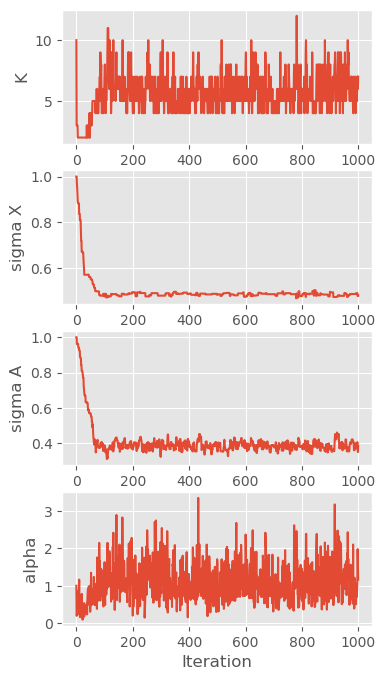

In [18]:
plt.rcdefaults()
plt.style.use('ggplot')

plt.figure(figsize=(4, 8))
plt.subplot(411)
plt.plot(np.arange(len(chain_K)), np.squeeze(chain_K, axis=(1,)))
plt.xlabel('Iteration')
plt.ylabel('K')

plt.subplot(412)
plt.plot(np.arange(len(chain_sigma_X)), np.squeeze(chain_sigma_X, axis=(1,)))
plt.xlabel('Iteration')
plt.ylabel('sigma X')

plt.subplot(413)
plt.plot(np.arange(len(chain_sigma_A)), np.squeeze(chain_sigma_A, axis=(1,)))
plt.xlabel('Iteration')
plt.ylabel('sigma A')

plt.subplot(414)
plt.plot(np.arange(len(chain_alpha)), np.squeeze(chain_alpha, axis=(1,)))
plt.xlabel('Iteration')
plt.ylabel('alpha')

plt.savefig('traceplots_simulation.png')